In [1]:
import cv2
import os
import shutil 
import math
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('dark_background')

# Data Preparation

In [2]:
# function to sort out cropped images
def FormatDataset(dataset_src, dataset_dest, classes):
    # Making a Copy of Dataset
    new_cropped_dest = [os.path.join(dataset_dest, cls)  for cls in classes]
    cropped_src = [ dataset_src + "/im_" + cls + "/im_" + cls +"/CROPPED"  for cls in classes ]
    for dest in new_cropped_dest:
        os.makedirs(dest)
        
    # Formating Cropped Images
    for (src,new_dest) in zip(cropped_src, new_cropped_dest):
        for file in os.listdir(src):
            filename, file_ext = os.path.splitext(file);
            if file_ext == '.bmp':
                #reading image
                img_des = os.path.join(new_dest, filename + '.jpg')
                img = cv2.imread(os.path.join(src, file))
                # Resizing and applying blur to images to smoothen it out
                img = cv2.resize(img, (128,128))
                img = cv2.blur(img, (2, 2))
                img_des = os.path.join(new_dest, filename + '.jpg')
                #saving image
                cv2.imwrite(img_des,img)
                """images.append(img)
                labels.append(label)"""

images=[]
labels=[]

# Source Location for Dataset
src = 'archive';
# Destination Location for Dataset
dest = './CervicalCancer';
# Image Classes
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"];
# Formatting Dataset
FormatDataset(src, dest, classes);

# Data Visulisation

In [3]:
Dyskeratotic_img = cv2.imread(r"CervicalCancer\Dyskeratotic\001_01.jpg")
Koilocytotic_ing = cv2.imread(r"CervicalCancer\Koilocytotic\001_01.jpg")
Metaplastic_img = cv2.imread(r"CervicalCancer\Metaplastic\001_01.jpg")
Parabasal = cv2.imread(r"CervicalCancer\Parabasal\001_01.jpg")
Superficial = cv2.imread(r"CervicalCancer\Superficial-Intermediate\001_01.jpg")

In [4]:
images = [Dyskeratotic_img,Koilocytotic_ing,Metaplastic_img,Parabasal,Superficial]


### RGB 

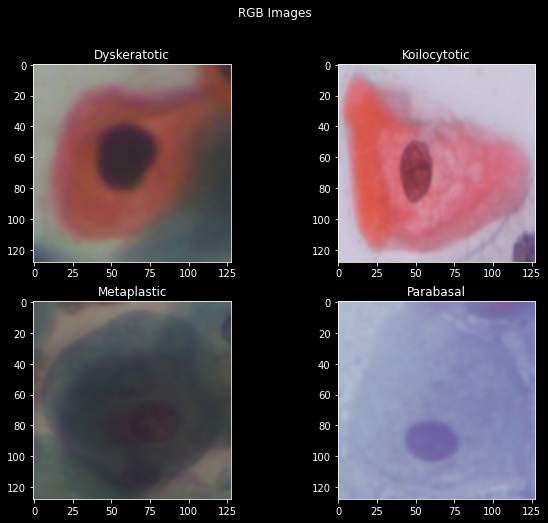

In [5]:
#plotting out original images
plt.figure(figsize=(12,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    img = cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(classes[i])
plt.suptitle("RGB Images")
plt.show()

### Gray Scaled

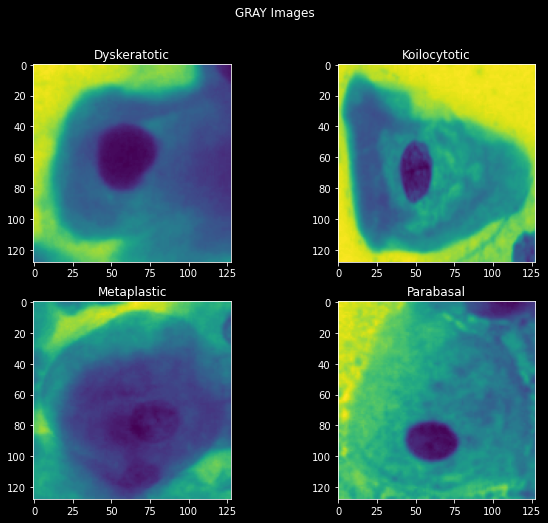

In [6]:

plt.figure(figsize=(12,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    
    img = cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
    # Converting Rgb image to GRAY images
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    plt.imshow(img)
    plt.title(classes[i])
plt.suptitle("GRAY Images")
plt.show()

### GaussianBlur

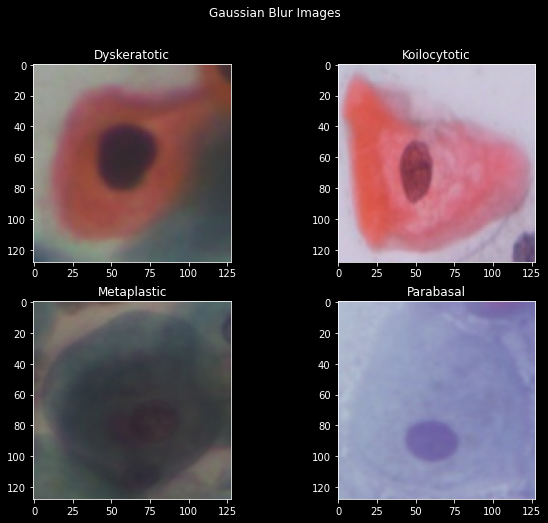

In [7]:
plt.figure(figsize=(12,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    
    img = cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
    #applying gaussian blur 
    blur = cv2.GaussianBlur(img, (5,5), 0)
    
    plt.imshow(img)
    plt.title(classes[i])
plt.suptitle("Gaussian Blur Images")
plt.show()

### Image Sharpening

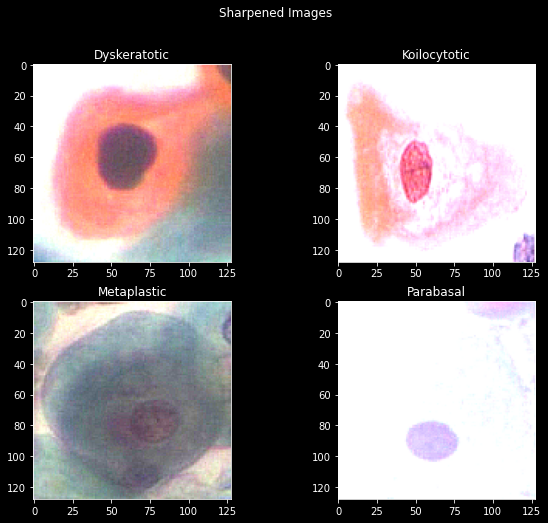

In [8]:
#defining kernel array for image sharpening
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1,10,-1], 
                              [-1,-1,-1]])


plt.figure(figsize=(12,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    
    img = cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
    # appling image sharpening kernel to image
    img = cv2.filter2D(img, -1, kernel_sharpening)
    
    plt.imshow(img)
    plt.title(classes[i])
plt.suptitle("Sharpened Images")
plt.show()

### Image Histogram

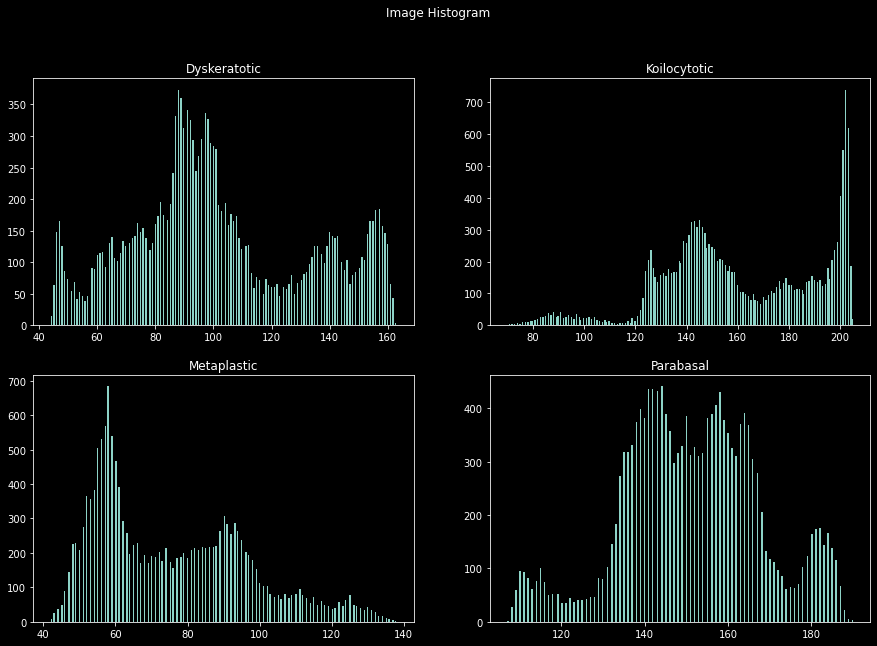

In [32]:
plt.figure(figsize=(15,12))
for i in range(5):
    plt.subplot(3,2,i+1)
    # converting BGR image to GRAY image
    img = cv2.cvtColor(images[i],cv2.COLOR_BGR2GRAY) 
    # Image Flattening
    plt.hist(img.ravel(), bins=256, ) 
    #Histogram plot
    plt.title(classes[i])
plt.suptitle("Image Histogram")
plt.show()

In [10]:
# Defining necessary arguments
datadir = "CervicalCancer/"
target_shape = [128,128,3]
height,width,depth = target_shape

train_batch_size = 16
val_batch_size = 4


In [11]:
# Image augmentation using ImageDataGenerator (Online augmentation)
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True,validation_split=0.2)
val_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,validation_split=0.2)

#Loading data from file
train_data = train_datagen.flow_from_directory(directory= datadir, target_size=(height,width), batch_size=train_batch_size, class_mode = 'categorical',subset="training")
val_data = val_datagen.flow_from_directory(directory= datadir, target_size=(height,width), batch_size=val_batch_size, class_mode = 'categorical',subset="validation")

Found 3241 images belonging to 5 classes.
Found 808 images belonging to 5 classes.


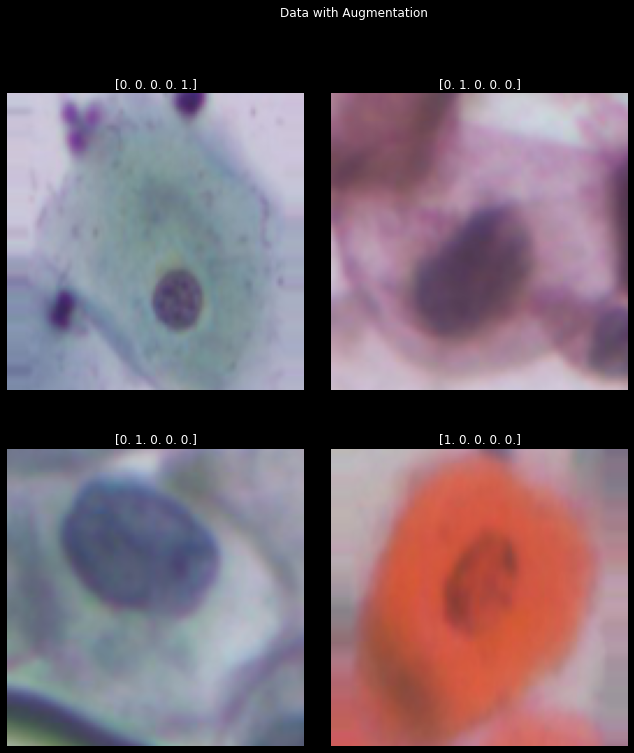

In [12]:
nrows = 2
ncols = 2

fig, axes = plt.subplots(nrows=nrows,ncols = ncols)
fig.set_size_inches(10,12)
# plotting sample images from data augmentation
temp_img = train_data.next()
for i in range(nrows*ncols):
    image = temp_img[0][i]
    
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(image)
    plt.title(temp_img[1][i])
    plt.axis('off')
plt.subplots_adjust(left = 0,wspace = 0,hspace = 0.2)
plt.suptitle("Data with Augmentation")
plt.show()

# Model comparative analysis

### InceptionV3

In [13]:
# defining preciosion and recall metrics
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [14]:
# Defining model 
model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(height,width,depth))
# Removing bottom layer and defining custom neural net classifier
model_InceptionV3 = tf.keras.models.Sequential()
model_InceptionV3.add(model)
model_InceptionV3.add(tf.keras.layers.Flatten())
model_InceptionV3.add(tf.keras.layers.Dropout(0.2))
model_InceptionV3.add(tf.keras.layers.BatchNormalization())
model_InceptionV3.add(tf.keras.layers.Dense(256, activation='relu'))
model_InceptionV3.add(tf.keras.layers.Dropout(0.5))

model_InceptionV3.add(tf.keras.layers.Dense(128, activation='relu'))

model_InceptionV3.add(tf.keras.layers.Dense(5, activation='softmax'))

model_InceptionV3.layers[0].trainable=False

In [15]:
# Model Compilation
model_InceptionV3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",precision,recall])
# Model Training
history_model_InceptionV3 = model_InceptionV3.fit(train_data,batch_size=train_batch_size,validation_data=val_data,epochs=50)

Epoch 1/50
203/203 [==============================] - 53s 189ms/step - loss: 1.2965 - accuracy: 0.6371 - precision: 0.6607 - recall: 0.6152 - val_loss: 0.8077 - val_accuracy: 0.7265 - val_precision: 0.7487 - val_recall: 0.7042
Epoch 2/50
203/203 [==============================] - 22s 108ms/step - loss: 0.9980 - accuracy: 0.6961 - precision: 0.7166 - recall: 0.6726 - val_loss: 0.6386 - val_accuracy: 0.7426 - val_precision: 0.7764 - val_recall: 0.7178
Epoch 3/50
203/203 [==============================] - 24s 118ms/step - loss: 0.7149 - accuracy: 0.7627 - precision: 0.7889 - recall: 0.7334 - val_loss: 0.5596 - val_accuracy: 0.7859 - val_precision: 0.8150 - val_recall: 0.7525
Epoch 4/50
203/203 [==============================] - 23s 116ms/step - loss: 0.6602 - accuracy: 0.7751 - precision: 0.8049 - recall: 0.7470 - val_loss: 0.5129 - val_accuracy: 0.8032 - val_precision: 0.8396 - val_recall: 0.7710
Epoch 5/50
203/203 [==============================] - 22s 108ms/step - loss: 0.6072 - accura

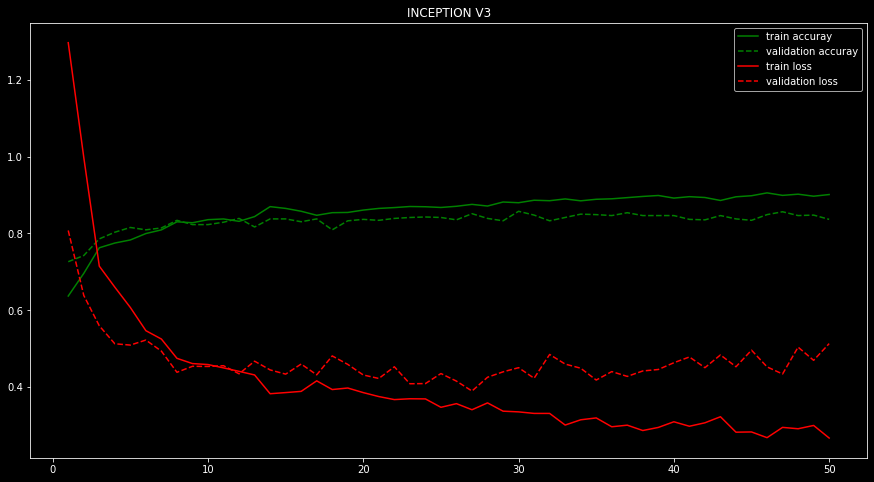

In [16]:
# plotting metrics 
xaxis = [i for i in range(1,51)]
plt.style.use('dark_background')
plt.figure(figsize=(15,8))
plt.title("INCEPTION V3")
plt.plot(xaxis,history_model_InceptionV3.history["accuracy"],color="g",label="train accuray")
plt.plot(xaxis,history_model_InceptionV3.history["val_accuracy"],"g--",label="validation accuray")
plt.plot(xaxis,history_model_InceptionV3.history["loss"],"r",label="train loss")
plt.plot(xaxis,history_model_InceptionV3.history["val_loss"],"r--",label="validation loss")
plt.legend()
plt.show()

### ResNet50

In [17]:
# Defining model 
model = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(height,width,depth))
# Removing bottom layer and defining custom neural net classifier
model_ResNet50 = tf.keras.models.Sequential()
model_ResNet50.add(model)
model_ResNet50.add(tf.keras.layers.Flatten())
model_ResNet50.add(tf.keras.layers.BatchNormalization())
model_ResNet50.add(tf.keras.layers.Dense(256, activation='relu'))
model_ResNet50.add(tf.keras.layers.Dropout(0.5))

model_ResNet50.add(tf.keras.layers.Dense(128, activation='relu'))

model_ResNet50.add(tf.keras.layers.Dense(5, activation='softmax'))

model_ResNet50.layers[0].trainable=False

In [18]:
# Model Compilation
model_ResNet50.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",precision, recall])
# Model Training
history_model_resnet50 = model_ResNet50.fit(train_data,batch_size=train_batch_size,validation_data=val_data,epochs=50)

Epoch 1/50
203/203 [==============================] - 32s 135ms/step - loss: 0.8937 - accuracy: 0.6520 - precision: 0.7708 - recall: 0.6056 - val_loss: 2.7644 - val_accuracy: 0.3515 - val_precision: 0.3459 - val_recall: 0.3304
Epoch 2/50
203/203 [==============================] - 25s 123ms/step - loss: 0.7168 - accuracy: 0.7171 - precision: 0.7714 - recall: 0.6581 - val_loss: 1.0794 - val_accuracy: 0.6015 - val_precision: 0.7304 - val_recall: 0.4493
Epoch 3/50
203/203 [==============================] - 25s 124ms/step - loss: 0.6263 - accuracy: 0.7646 - precision: 0.8029 - recall: 0.7078 - val_loss: 0.8214 - val_accuracy: 0.7413 - val_precision: 0.7824 - val_recall: 0.7030
Epoch 4/50
203/203 [==============================] - 27s 134ms/step - loss: 0.6217 - accuracy: 0.7624 - precision: 0.7964 - recall: 0.7180 - val_loss: 0.6398 - val_accuracy: 0.7611 - val_precision: 0.8476 - val_recall: 0.7092
Epoch 5/50
203/203 [==============================] - 27s 135ms/step - loss: 0.5816 - accura

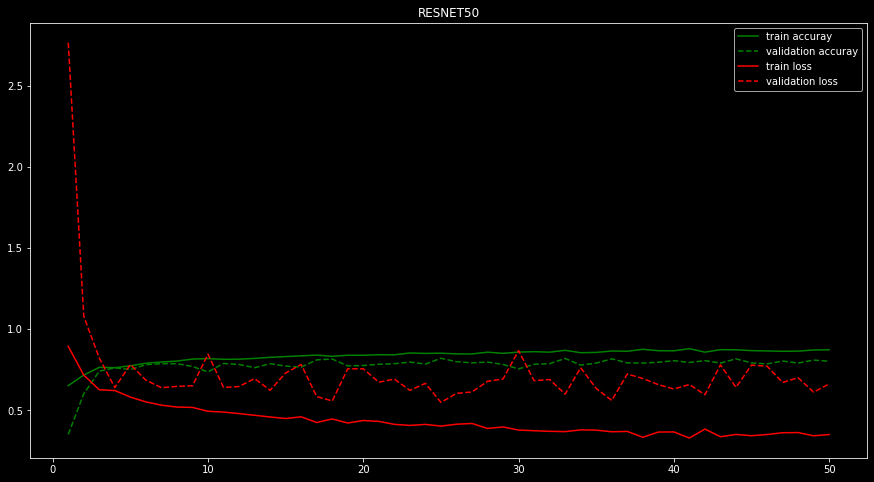

In [19]:
# plotting metrics 
xaxis = [i for i in range(1,51)]
plt.style.use('dark_background')
plt.figure(figsize=(15,8))
plt.title("RESNET50")
plt.plot(xaxis,history_model_resnet50.history["accuracy"],color="g",label="train accuray")
plt.plot(xaxis,history_model_resnet50.history["val_accuracy"],"g--",label="validation accuray")
plt.plot(xaxis,history_model_resnet50.history["loss"],"r",label="train loss")
plt.plot(xaxis,history_model_resnet50.history["val_loss"],"r--",label="validation loss")
plt.legend()
plt.show()

### VGG 19

In [20]:
# Defining model 
model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(height,width,depth))
# Removing bottom layer and defining custom neural net classifier
model_vgg19 = tf.keras.models.Sequential()
model_vgg19.add(model)
model_vgg19.add(tf.keras.layers.Flatten())
model_vgg19.add(tf.keras.layers.BatchNormalization())
model_vgg19.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg19.add(tf.keras.layers.Dropout(0.5))

model_vgg19.add(tf.keras.layers.Dense(128, activation='relu'))

model_vgg19.add(tf.keras.layers.Dense(5, activation='softmax'))

model_vgg19.layers[0].trainable=False

In [21]:
# Model Compilation
model_vgg19.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",precision, recall])
# Model Training
history_model_vgg19 = model_vgg19.fit(train_data,batch_size=train_batch_size,validation_data=val_data,epochs=50)

Epoch 1/50
203/203 [==============================] - 36s 162ms/step - loss: 1.1327 - accuracy: 0.6952 - precision: 0.7439 - recall: 0.6952 - val_loss: 0.7708 - val_accuracy: 0.7673 - val_precision: 0.8996 - val_recall: 0.5767
Epoch 2/50
203/203 [==============================] - 25s 123ms/step - loss: 0.7062 - accuracy: 0.7840 - precision: 0.8042 - recall: 0.7627 - val_loss: 0.5229 - val_accuracy: 0.8280 - val_precision: 0.8989 - val_recall: 0.7809
Epoch 3/50
203/203 [==============================] - 24s 119ms/step - loss: 0.5697 - accuracy: 0.8109 - precision: 0.8308 - recall: 0.7893 - val_loss: 0.5012 - val_accuracy: 0.8465 - val_precision: 0.8804 - val_recall: 0.8106
Epoch 4/50
203/203 [==============================] - 26s 127ms/step - loss: 0.4861 - accuracy: 0.8297 - precision: 0.8529 - recall: 0.8087 - val_loss: 0.4579 - val_accuracy: 0.8540 - val_precision: 0.8796 - val_recall: 0.8230
Epoch 5/50
203/203 [==============================] - 29s 144ms/step - loss: 0.4323 - accura

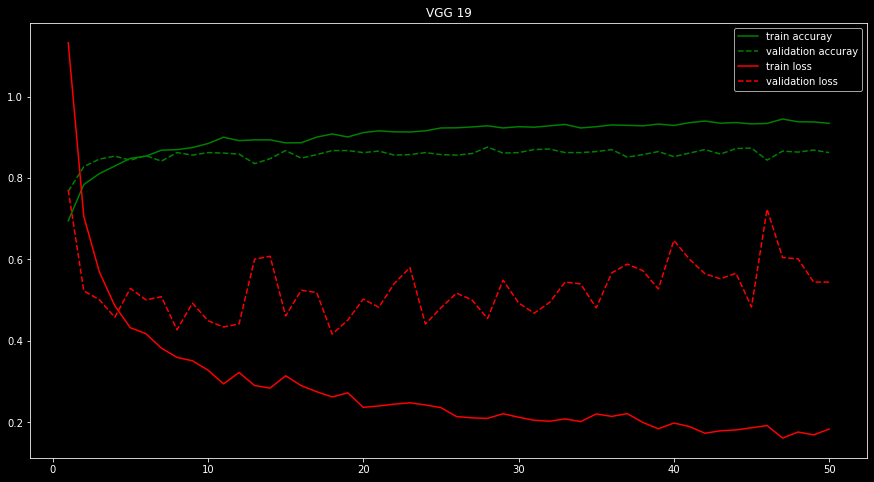

In [22]:
# plotting metrics 
xaxis = [i for i in range(1,51)]
plt.style.use('dark_background')
plt.figure(figsize=(15,8))
plt.title("VGG 19")
plt.plot(xaxis,history_model_vgg19.history["accuracy"],color="g",label="train accuray")
plt.plot(xaxis,history_model_vgg19.history["val_accuracy"],"g--",label="validation accuray")
plt.plot(xaxis,history_model_vgg19.history["loss"],"r",label="train loss")
plt.plot(xaxis,history_model_vgg19.history["val_loss"],"r--",label="validation loss")
plt.legend()
plt.show()

### Custom Model

In [23]:
train_data = train_datagen.flow_from_directory(directory= datadir, target_size=(64,64), batch_size=train_batch_size, class_mode = 'categorical',subset="training")
val_data = val_datagen.flow_from_directory(directory= datadir, target_size=(64,64), batch_size=val_batch_size, class_mode = 'categorical',subset="validation")

Found 3241 images belonging to 5 classes.
Found 808 images belonging to 5 classes.


In [24]:
# Defining model 
custom_model = tf.keras.models.Sequential()
# Block 1 --> 64 layers
custom_model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(64,64,depth), activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Block 2 --> 128 layers
custom_model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
custom_model.add(tf.keras.layers.BatchNormalization())
# Block 3 --> 256 layers
custom_model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
custom_model.add(tf.keras.layers.BatchNormalization())
# Block 4 --> 256 layers
custom_model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
custom_model.add(tf.keras.layers.BatchNormalization())
# Flatten
custom_model.add(tf.keras.layers.Flatten())
# Block 5 --> 512 Neurons
custom_model.add(tf.keras.layers.Dense(512, activation='relu',input_dim=128))
custom_model.add(tf.keras.layers.Dropout(0.2))
custom_model.add(tf.keras.layers.BatchNormalization())
# Block 6 --> 256 Neurons
custom_model.add(tf.keras.layers.Dense(256, activation='relu'))
# Block 7 --> 128 Neurons
custom_model.add(tf.keras.layers.Dense(128, activation='relu'))

custom_model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [25]:
# Model Compilation
custom_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",precision,recall])
# Model Training
history_custom_model = custom_model.fit(train_data,batch_size=train_batch_size,validation_data=val_data,epochs=50)

Epoch 1/50
203/203 [==============================] - 23s 93ms/step - loss: 0.8682 - accuracy: 0.6837 - precision: 0.7640 - recall: 0.6708 - val_loss: 3.5524 - val_accuracy: 0.1943 - val_precision: 0.1943 - val_recall: 0.1943
Epoch 2/50
203/203 [==============================] - 17s 86ms/step - loss: 0.6040 - accuracy: 0.7729 - precision: 0.8001 - recall: 0.7374 - val_loss: 1.7312 - val_accuracy: 0.4059 - val_precision: 0.4332 - val_recall: 0.3812
Epoch 3/50
203/203 [==============================] - 17s 86ms/step - loss: 0.5581 - accuracy: 0.7902 - precision: 0.8191 - recall: 0.7600 - val_loss: 1.7463 - val_accuracy: 0.5891 - val_precision: 0.6186 - val_recall: 0.5842
Epoch 4/50
203/203 [==============================] - 18s 88ms/step - loss: 0.4657 - accuracy: 0.8300 - precision: 0.8527 - recall: 0.8041 - val_loss: 2.1313 - val_accuracy: 0.5743 - val_precision: 0.5859 - val_recall: 0.5656
Epoch 5/50
203/203 [==============================] - 18s 87ms/step - loss: 0.4112 - accuracy: 0

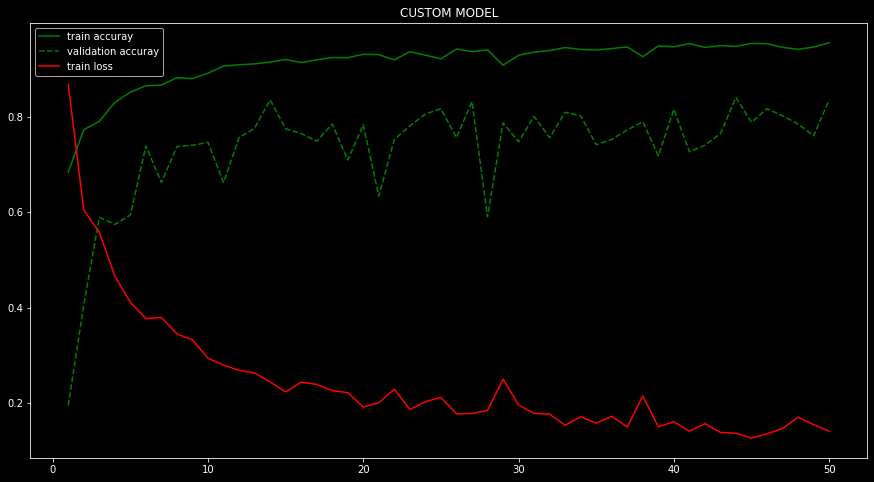

In [31]:
xaxis = [i for i in range(1,51)]
plt.style.use('dark_background')
plt.figure(figsize=(15,8))
plt.title("CUSTOM MODEL")
plt.plot(xaxis,history_custom_model.history["accuracy"],color="g",label="train accuray")
plt.plot(xaxis,history_custom_model.history["val_accuracy"],"g--",label="validation accuray")
plt.plot(xaxis,history_custom_model.history["loss"],"r",label="train loss")
plt.legend()
plt.show()

# All Model Comparison

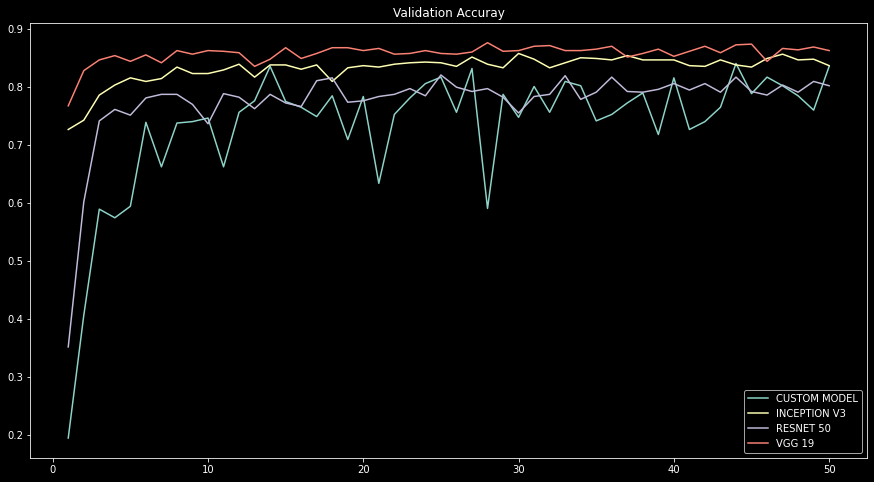

In [27]:
plt.style.use('dark_background')
plt.figure(figsize=(15,8))
plt.title("Validation Accuray")
plt.plot(xaxis,history_custom_model.history["val_accuracy"],label="CUSTOM MODEL")
plt.plot(xaxis,history_model_InceptionV3.history["val_accuracy"],label="INCEPTION V3")
plt.plot(xaxis,history_model_resnet50.history["val_accuracy"],label="RESNET 50")
plt.plot(xaxis,history_model_vgg19.history["val_accuracy"],label="VGG 19")
plt.legend()
plt.show()

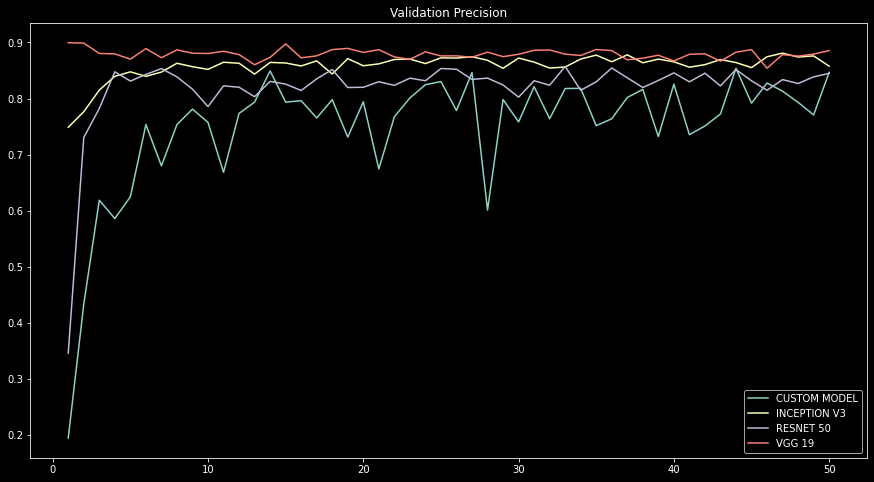

In [28]:
plt.style.use('dark_background')
plt.figure(figsize=(15,8))
plt.title("Validation Precision")
plt.plot(xaxis,history_custom_model.history["val_precision"],label="CUSTOM MODEL")
plt.plot(xaxis,history_model_InceptionV3.history["val_precision"],label="INCEPTION V3")
plt.plot(xaxis,history_model_resnet50.history["val_precision"],label="RESNET 50")
plt.plot(xaxis,history_model_vgg19.history["val_precision"],label="VGG 19")
plt.legend()
plt.show()

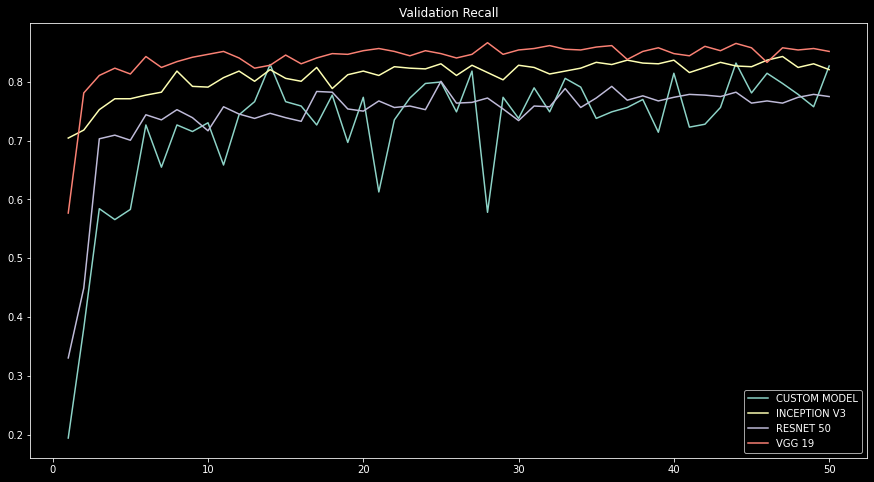

In [29]:
plt.style.use('dark_background')
plt.figure(figsize=(15,8))
plt.title("Validation Recall")
plt.plot(xaxis,history_custom_model.history["val_recall"],label="CUSTOM MODEL")
plt.plot(xaxis,history_model_InceptionV3.history["val_recall"],label="INCEPTION V3")
plt.plot(xaxis,history_model_resnet50.history["val_recall"],label="RESNET 50")
plt.plot(xaxis,history_model_vgg19.history["val_recall"],label="VGG 19")
plt.legend()
plt.show()